In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_video, read_video_timestamps

In [2]:
VIDEO1_PATH = "resource/owl1.mp4"
VIDEO2_PATH = "resource/owl2.mp4"

## torchvision.io.read_video

In [3]:
%%time
vframes, aframes, info = read_video(VIDEO1_PATH, pts_unit="sec")

CPU times: user 3.15 s, sys: 671 ms, total: 3.82 s
Wall time: 3.84 s


`vframes` には `[frames, Height, Weight, Channels]` の4次元配列が格納されている。

In [4]:
vframes.shape    # [frames, H, W, C]

torch.Size([997, 480, 640, 3])

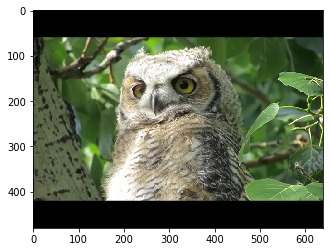

In [5]:
plt.imshow(vframes[0])
plt.show()

`aframes` は オーディオ。 `[K, L]` で `K` ... チャンネル数、 `L` はデータ点

In [6]:
aframes.shape

torch.Size([2, 1463296])

In [7]:
info

{'video_fps': 29.97, 'audio_fps': 44100}

## torchvision.io.read_video_timestamps

In [8]:
%%time
sec, video_fps = read_video_timestamps(VIDEO1_PATH, pts_unit="sec")

CPU times: user 2.09 s, sys: 168 ms, total: 2.26 s
Wall time: 2.33 s


In [9]:
print("len of pts: ", len(sec))
print("contain", sec[:5])

len of pts:  997
contain [Fraction(0, 1), Fraction(100, 2997), Fraction(200, 2997), Fraction(100, 999), Fraction(400, 2997)]


In [10]:
video_fps

29.97

## Torch Video Dataset

### Video Resize

In [11]:
class VideoToPIL:
    def __init__(self):
        self.pil = transforms.ToPILImage()
    
    def __call__(self, images):
        if isinstance(images, torch.Tensor):
            images = images.numpy()
        return [self.pil(img) for img in images]

class VideoResize:
    def __init__(self, size):
        self.scaler = transforms.Resize(size)
    
    def __call__(self, images):
        return [self.scaler(img) for img in images]

    
class VideoToTensor:
    def __init__(self):
        self.to_tensor = transforms.ToTensor()
        
    def __call__(self, images):
        return torch.stack([self.to_tensor(img) for img in images])


In [12]:
class VideoDataset(Dataset):
    def __init__(self, path, n_segments, transform=None):
        self.path = path
        self.items = os.listdir(path)
        self.transform = transform
        self.n_segments = n_segments
    
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, item):
        path = self.path + self.items[item]
        v, _, _ = read_video(path, pts_unit="sec")
        indices = self._get_indices(len(v))
        v = self.transform(v[indices])
        return v
    
    def _get_indices(self, n_frames):
        tick = n_frames / float(self.n_segments)
        indices = np.array([int(tick / 2.0 + tick * x) for x in range(self.n_segments)]) + 1
        return indices

In [13]:
transform = transforms.Compose([
    VideoToPIL(),
    VideoResize([256, 256]),
    VideoToTensor()
])
ds = VideoDataset("resource/", 30, transform)
loader = DataLoader(ds, batch_size=2)

In [14]:
a = next(iter(loader))
a.shape

torch.Size([2, 30, 3, 256, 256])

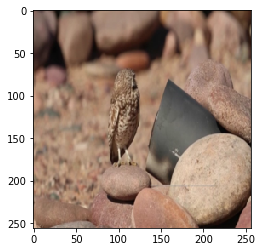

In [15]:
plt.imshow(a[0][0].permute(1, 2, 0))
plt.show()

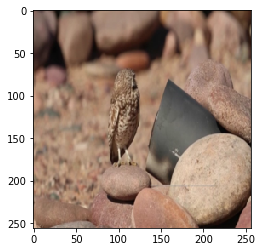

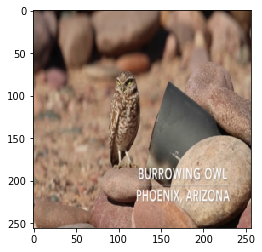

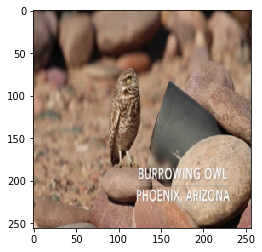

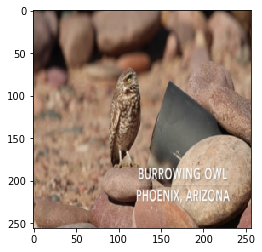

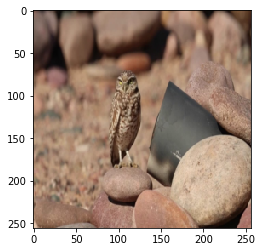

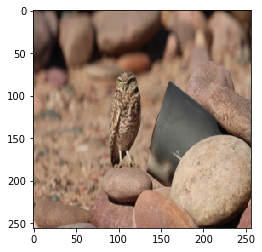

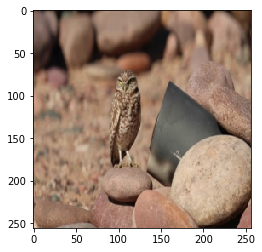

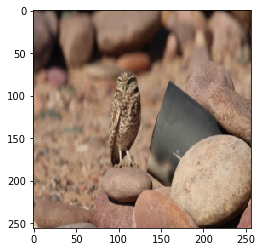

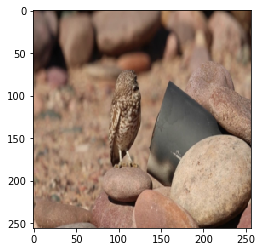

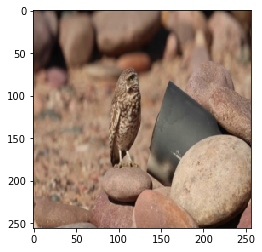

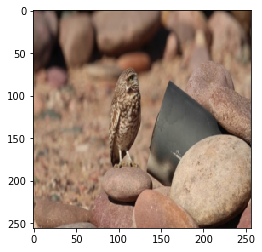

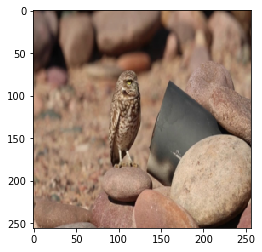

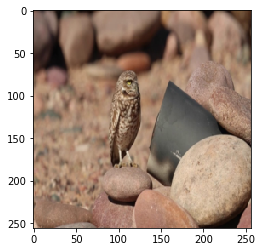

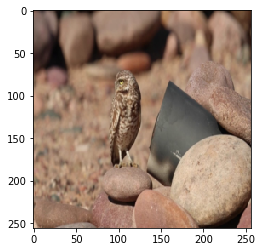

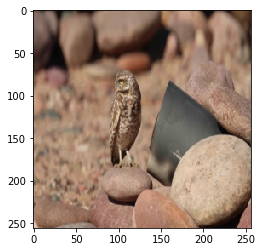

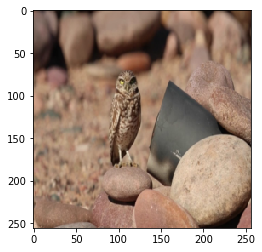

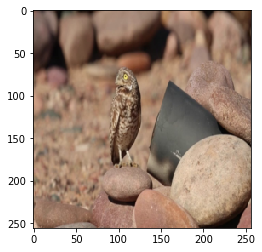

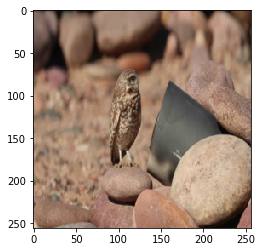

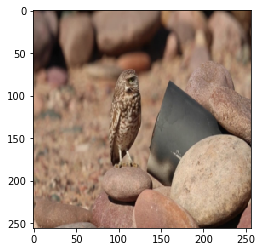

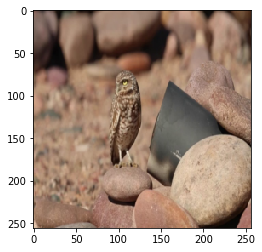

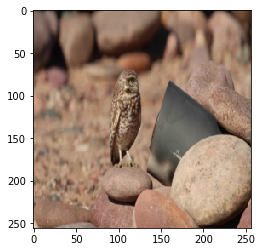

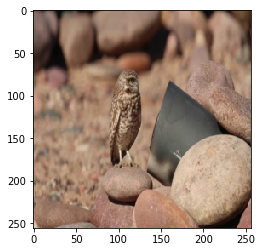

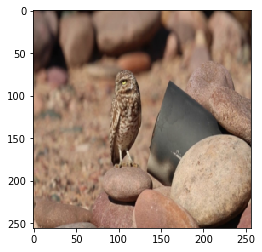

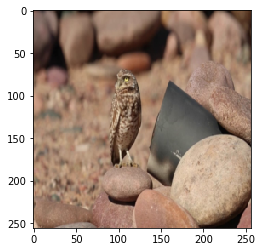

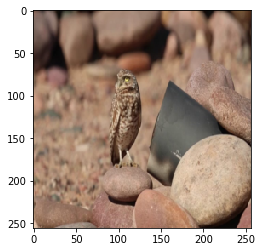

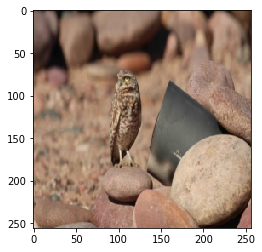

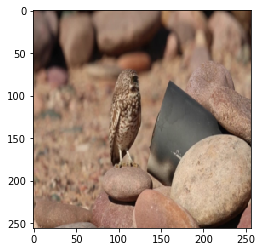

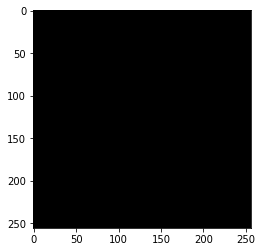

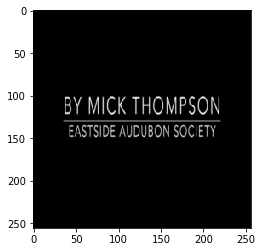

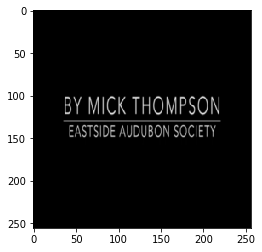

In [16]:
for i in range(len(a[0])):
    plt.imshow(a[0][i].permute(1, 2, 0))
    plt.show()